# **New or Used - Product Type**

## Data Wrangling Step
## Felipe Daiha Alves

# **Goal**

Report of the *Exploratory Data Analysis* first stage, containing informations about the process of **data wrangling** phase. The main goal here is to make a **data cleaning in the entire dataset** and prepare it to be future analyzed.

# **Environment**

Initially, we will carry out the **preparation of the work environment**, so that the dataset is ready to be cleaned.

### **Importing Required Packages**

In [1]:
import logging
import sys
import os
from warnings import filterwarnings
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq

### **Functions**

##### 1 - logger_config

In [2]:
def logger_config():
    """
    Configurate logger format for monitoring steps in DWR pipeline.
    """
    # Var logger
    logger = logging.getLogger("Logger")
    logger.setLevel(logging.DEBUG)
    # Creating formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # Console handler to set level and add formatter to handler
    handler = logging.StreamHandler()
    handler.setLevel(logging.DEBUG)
    handler.setFormatter(formatter)
    # Adding handlers to feature 'logger'
    logger.addHandler(handler)
    # Returning log configuration
    return logger

##### 2 - proportion_target_date

In [3]:
def proportion_target_date(data: pd.DataFrame, target: str, date_column: str):
    """
    Build dataframe to analyze condition proportion
    over a time period.
    """
    try:
        # Group by target and date_column and count the occurrences
        count_by_condition_date = data.groupby([target, date_column]).size().reset_index(name='count_condition_date')
        # Sort by datetime
        count_by_condition_date = count_by_condition_date.sort_values(by=[date_column])
        # Count by date_column
        count_by_condition = data.groupby([date_column]).size().reset_index(name='count_date')
        # Merging dataframes to calculate percentage
        count_final = count_by_condition_date.merge(count_by_condition, on=date_column, how="left")
        # New column 'perc_condition_date'
        count_final["perc_condition_date"] = count_final["count_condition_date"]/count_final["count_date"]
        # Execution success log
        log.info("Create dataframe to analyze %s proportion over %s succesfully done!", target, date_column)
        # Return dataframe
        return count_final
    except ImportError:
        # Execution error log
        log.error(
            "Something went wrong... Could not create dataframe to analyze %s proportion over %s!", target, date_column
        )

##### 3 - lineplot_target_date

In [4]:
def lineplot_target_date(data: pd.DataFrame, date_column: str, target: str, y_axis: str, threshold: str):
    """
    Lineplot to view proportion from target column over time.
    """
    try:
        # Pivot the dataframe to reshape it
        pivot_df = data.pivot(index=date_column, columns=target, values=y_axis)
        # Create a line plot of the pivoted dataframe
        pivot_df.plot(kind='line', marker='o', legend=True)
        # Add axis labels, legend and title name
        plt.title(f"{y_axis} by {target} over {date_column}")
        plt.xlabel(date_column)
        plt.ylabel(y_axis)
        plt.legend()
        # Add the vertical line
        plt.axvline(x=pivot_df.index.get_loc(threshold), color='r', linestyle='--')
        # Execution success log
        log.info("Succesfully create lineplot for '%s' by '%s' over '%s'!", y_axis, target, date_column)
        # Show lineplot
        return plt.show()
    except ImportError:
        # Execution error log
        log.error(
            "Something went wrong... Could not create lineplot for '%s' by '%s' over '%s'!", y_axis, target, date_column
        )

##### 4 - unique_values

In [5]:
def unique_values(data: pd.DataFrame):
    """
    Count unique values for each column in a pandas dataframe.
    """
    try:
        # Iterate over all column names of Dataframe
        for col in data.columns:
            # Select the column by name and get count of unique values in it
            count = data[col].astype('str').nunique()
            print(f"Column: '{col}' <> Unique values: {count}")
        # Execution success log
        log.info("Unique values succesfully counted for each column!")
    except ImportError:
        # Execution error log
        log.error("Something went wrong... Could not count unique values in this dataframe!")

##### 5 - non_null_columns

In [6]:
def non_null_columns(data: pd.DataFrame, column_list: list):
    """
    Count not zero values in pandas dataframe
    where the column is a list object.
    """
    try:
        print("'non_zero_list_columns' function results:\n")
        # Loop to print results
        for col in column_list:
            non_zero_values = len(data[[bool(x) for x in data[col]]])
            print(f"- Feature '{col}' <> Non Null Values = {non_zero_values}")
        # Execution success log
        log.info("Count not null values in a column succesfully done!")
    except ImportError:
        # Execution error log
        log.error("Something went wrong... Could not count not null values in this dataframe!")

##### 6 - dict_columns_inspect

In [7]:
def dict_columns_inspect(data_in_list: list):
    """
    Checking informations about nested values
    in dict columns of the raw dataset.
    """
    # For each dataframe stored in the list, print some informations about it.
    try:
        for i in range(0, len(data_in_list)):
            dataframe = data_in_list[i]
            print(dataframe.info())
            DIVISOR_MARK = "-" * 90
            print(f"\n{DIVISOR_MARK}\n")
            print(dataframe)
            DATAFRAME_MARK = "=^=" * 30
            print(f"\n{DATAFRAME_MARK}\n")
        # Execution success log
        log.info("Checking nested informations succesfully done!")
    except ImportError:
        # Execution error log
        log.error("Something went wrong... Could not check nested informations in dictionary columns!")

##### 7 - explode_elements

In [8]:
def explode_elements(data: pd.DataFrame, list_columns: list):
    """
    Function to explode list elements in each row
    of a pandas dataframe.
    """
    try:
        # Empty list to store results
        store_exploded_elements = []
        # For each element in list
        for col in list_columns:
            # Explode elements
            exploded_df = data.explode(col)
            # Bring only necessary infos
            wrangler_df = exploded_df.loc[:, ["id", col]]
            # Drop duplicated values
            wrangler_df = wrangler_df[~wrangler_df.astype(str).duplicated()]
            # Append value to list
            store_exploded_elements.append(wrangler_df)
        # Execution success log
        log.info("Separate rows from column list succesfully done!")
        # Returning final result
        return store_exploded_elements
    except ImportError:
        # Execution error log
        log.error("Something went wrong... Could not separate rows from column lists!")

##### 8 - explode_normalize_lists

In [9]:
def explode_normalize_lists(data: pd.DataFrame, list_columns: list):
    """
    Function to separate list elements in a row
    and convert the dicts inside in pandas dataframe format.
    """
    try:
        # Empty list to store results
        store_exploded = []
        # For each element in list
        for col in list_columns:
            # Explode elements
            exploded_df = data.explode(col)
            # Normalize exploded rows
            normalized_col = (
                pd.json_normalize(
                    exploded_df[col]
                ).set_index(
                    exploded_df.index
                ).add_prefix(
                    f'{col}_'
                )
            )
            # Join with index
            wrangler_df = exploded_df.loc[:, ["id"]].join(
                normalized_col
            )
            # Drop duplicated values
            #wrangler_df = wrangler_df.drop_duplicates()
            wrangler_df = wrangler_df[~wrangler_df.astype(str).duplicated()]
            # Append value to list
            store_exploded.append(wrangler_df)
        # Execution success log
        log.info("Explode lists and normalize dictionaries succesfully done!")
        # Returning final result
        return store_exploded
    except ImportError:
        # Execution error log
        log.error("Something went wrong... Could not explode lists and normalize dictionaries!")

##### 9 - price_hist_plot

In [10]:
def price_hist_plot(data: pd.DataFrame, quantile: float):
    """
    Create plot for distribution of 'price' features
    to analyse what to do with the values of them.
    """
    try:
        # Create a copy of the original dataframe
        price_view = data.copy()
        # Extract 'price' cols in a list
        price_cols = [col for col in price_view.columns if 'price' in col]
        # Extract quantile value of each column
        quantile_limit = price_view[price_cols].quantile(quantile)
        # In the copy dataframe, replace values over quantile per each quantile limit
        price_view[price_cols] = price_view[
                price_cols].mask(
                        price_view[price_cols] > quantile_limit, quantile_limit, axis=1)
        # Temporarily append condition to create final dataset
        price_cols.append("condition")
        price_view = price_view.loc[:, price_cols]
        # Remove target from price list
        price_cols.remove("condition")
        # Create plot, grouped by target
        price_plot = price_view[price_cols].hist(
            by=price_view['condition']
        )
        plt.legend(price_cols)
        # Execution success log
        log.info("Create process 'price_hist_plot' succesfully done!")
        # Returning results
        return price_plot
    except ImportError:
        # Execution error log
        log.error("Something went wrong... Could not create 'price_hist_plot'!")

##### 10 - merge_dfs_list_index

In [11]:
def merge_dfs_list_index(output_list: list):
    """
    Merge all dataframes stored in a list
    """
    try:
        merging = reduce(
            lambda x, y: pd.merge(
                x, y, left_index=True, right_index=True
            ), output_list
        )
        # Execution success log
        log.info("Merging dataframes in a list by index succesfully done!")
        # Return result
        return merging
    except ImportError:
        # Execution error log
        log.error("Something went wrong... Could not merge dataframe in a list by index!")    

##### 11 - df_from_explode_no_json

In [12]:
def df_from_explode_no_json(target_list: list, id_column="id"):
    """
    Creating a pandas dataframe, based on data
    stored in list from lists columns.
    The features are transformed into 'count'
    for objects and 'median' for numericals.
    """
    try:
        # Declaring an empty list to store results
        summarized_exploded = []
        # Looping over dataframes from list
        for i in range(0, len(target_list)):
            # Extract columns name and remove "id"
            columns = target_list[i].columns.tolist()
            columns.remove(id_column)
            """ Creating a loop over each column and check it's type.
            If it's an object, count it; A numerical feature, median.
            Else, do nothing """
            for col in columns:
                if isinstance(target_list[i][col], object):
                    pivot_sum = pd.pivot_table(
                        target_list[i],
                        index='id',
                        columns=col,
                        aggfunc=len,
                        fill_value=0
                    )
                    pivot_sum = pivot_sum.add_prefix(f'{col}_count_').reset_index()
                    summarized_exploded.append(pivot_sum)
                elif isinstance(target_list[i][col], (int, float)):
                    pivot_sum = pd.pivot_table(
                        target_list[i],
                        index='id',
                        columns=col,
                        aggfunc=np.median
                    )
                    pivot_sum = pivot_sum.add_prefix(f'{col}_median_').reset_index()
                    summarized_exploded.append(pivot_sum)
                else:
                    pass
            # After every append to list, merge them into a single pandas dataframe
            df_results_from_pivot = merge_dfs_list_index(output_list=summarized_exploded)
            # Execution success log
            log.info("Summarizing nested informations succesfully done!")
            # Returning results
            return df_results_from_pivot
    except ImportError:
        # Execution error log
        log.error("Something went wrong... Could not summarize nested informations from data!")  

##### 12 - count_from_jsons

In [13]:
def count_from_jsons(zip_list: list):
    """
    Count rows from normalized json column
    stored in previous list.
    """
    try:
        # Empty list to store future from loop
        count_list = []
        # Looping over dataframes from zipped list
        for i in range(0, len(zip_list)):
            # Extract 'id' and f'{column}_id' to a list
            ids_cols = [
                col for col in data_name_list[i][0].columns if 'id' == col or
                f"{data_name_list[i][1]}_id" in col
            ]
            # If list length equal to 2, then do aggregate function, else pass
            if len(ids_cols) == 2:
                # Count rows per id
                count_df = data_name_list[i][0].groupby("id")[ids_cols[1]].count().reset_index()
                # Renaming aggregate columns
                count_df = count_df.rename(columns={count_df.columns[1]: f"{ids_cols[1]}_count"})
                # Append result to the empty list
                count_list.append(count_df)
            else:
                pass
        # After every append to list, merge them into a single pandas dataframe
        df_results_from_counter = reduce(
            lambda x, y: pd.merge(
                x, y, on="id"
            ), count_list
        )
        # Execution success log
        log.info("Count rows after normalize jsons in each one succesfully done!")
        # Returning final results
        return df_results_from_counter
    except ImportError:
        # Execution error log
        log.error("Something went wrong... Could not count rows for each normalized json!")

### **Settings**

##### Config some options

In [14]:
# Declare logger default
log = logger_config()

# Filtering to suppress warnings
filterwarnings("ignore")

# Display pandas formats
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Dimensions of the plots
plt.rcParams['figure.figsize'] = [10, 6]

##### Loading json file as pandas dataframe

In [15]:
try:
    # Declaring strings to file path
    LOCAL_PATH = os.path.dirname(os.getcwd())
    FILE_NAME = "MLA_100k_checked_v3.jsonlines"
    # Importing dataset
    raw_new_or_used = pd.read_json(
        os.path.join(LOCAL_PATH, FILE_NAME),
        lines=True
    )
    # Execution success log
    log.info("Json file as pandas dataframe loading process succesfully done!")
    # Delete temp variables
    del LOCAL_PATH, FILE_NAME
except ImportError:
    # Execution error log
    log.error("Something went wrong... Could not load json file as pandas dataframe!")

2023-02-28 12:31:43,460 - Logger - INFO - Json file as pandas dataframe loading process succesfully done!


##### First look at the dataframe

In [16]:
# Showing some rows of the current dataframe
raw_new_or_used.head(5)

,seller_address,warranty,sub_status,condition,deal_ids,base_price,shipping,non_mercado_pago_payment_methods,seller_id,variations,site_id,listing_type_id,price,attributes,buying_mode,tags,listing_source,parent_item_id,coverage_areas,category_id,descriptions,last_updated,international_delivery_mode,pictures,id,official_store_id,differential_pricing,accepts_mercadopago,original_price,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity
0,"{'country': {'name': 'Argentina', 'id': 'AR'},...",None,[],new,[],80.000,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8208882349,[],MLA,bronze,80.000,[],buy_it_now,[dragged_bids_and_visits],,MLA6553902747,[],MLA126406,[{'id': 'MLA4695330653-912855983'}],2015-09-05T20:42:58.000Z,none,"[{'size': '500x375', 'secure_url': 'https://a2...",MLA4695330653,NaN,NaN,True,NaN,ARS,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,Auriculares Samsung Originales Manos Libres Ca...,False,2015-09-05T20:42:53.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-04 20:42:53,active,None,NaN,NaN,1,2015-09-05 20:42:53,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1
1,"{'country': {'name': 'Argentina', 'id': 'AR'},...",NUESTRA REPUTACION,[],used,[],2650.000,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8141699488,[],MLA,silver,2650.000,[],buy_it_now,[],,MLA7727150374,[],MLA10267,[{'id': 'MLA7160447179-930764806'}],2015-09-26T18:08:34.000Z,none,"[{'size': '499x334', 'secure_url': 'https://a2...",MLA7160447179,NaN,NaN,True,NaN,ARS,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2015-09-26T18:08:30.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-25 18:08:30,active,None,NaN,NaN,1,2015-09-26 18:08:30,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1
2,"{'country': {'name': 'Argentina', 'id': 'AR'},...",None,[],used,[],60.000,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8386096505,[],MLA,bronze,60.000,[],buy_it_now,[dragged_bids_and_visits],,MLA6561247998,[],MLA1227,[{'id': 'MLA7367189936-916478256'}],2015-09-09T23:57:10.000Z,none,"[{'size': '375x500', 'secure_url': 'https://a2...",MLA7367189936,NaN,NaN,True,NaN,ARS,http://mla-s1-p.mlstatic.com/22076-MLA73671899...,"Antigua Revista Billiken, N° 1826, Año 1954",False,2015-09-09T23:57:07.000Z,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-08 23:57:07,active,None,NaN,NaN,1,2015-09-09 23:57:07,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1
3,"{'country': {'name': 'Argentina', 'id': 'AR'},...",None,[],new,[],580.000,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",5377752182,[],MLA,silver,580.000,[],buy_it_now,[],,None,[],MLA86345,[{'id': 'MLA9191625553-932309698'}],2015-10-05T16:03:50.306Z,none,"[{'size': '441x423', 'secure_url': 'https://a2...",MLA9191625553,NaN,NaN,True,NaN,ARS,http://mla-s2-p.mlstatic.com/183901-MLA9191625...,Alarma Guardtex Gx412 Seguridad Para El Automo...,False,2015-09-28T18:47:56.000Z,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,2015-12-04 01:13:16,active,None,NaN,NaN,1,2015-09-28 18:47:56,http://articulo.mercadolibre.com.ar/MLA9191625...,0,1
4,"{'country': {'name': 'Argentina', 'id': 'AR'},...",MI REPUTACION.,[],used,[],30.000,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",2938071313,[],MLA,bronze,30.000,[],buy_it_now,[dragged_bids_and_visits],,MLA3133256685,[],MLA41287,[{'id': 'MLA7787961817-902981678'}],2015-08-28T13:37:41.000Z,none,"[{'size': '375x500', 'secure_url': 'https://a2...",MLA7787961817,NaN,NaN,True,NaN,ARS,http://mla-s2-p.mlstatic.com/13595-MLA77879618...,Serenata - Jennifer Blake,False,2015-08-24T2

# **Why not read with *new_or_used.py*?**

The reason for NOT USING the provided function was because:

1 - I wanted to see the dataframe in its **entirety** initially to carry out the proper *data wrangling* and *analysis*.

2 - Mainly, the function generates a split of data according to the index of the loaded dataset. **Is this indeed the appropriate way to train the model?** This split does not consider factors such as:

(a) The **proportion of classes** between *train-test*; \
(b) Nor the **temporal effect** of product date creation (*date_created*), used in the *cross-validation* process by defining the *custom folds* (see *model.ipynb*); \
(c) Multiplicity of data combinations to avoid **overfitting/underfitting**.

Therefore, for a more adequate training and greater generalization of the model, the data reading and the training and test splits **were done separately**.

# **About the model approach**

All of the cleaning process and the future analysis generated below will be based on the following modeling idea:

The future model will try to predict whether a product condition is *new or used* just **BEFORE the ad is published on the Mercado Libre's marketplace**. The reason for this is to prevent buyer customers from **purchasing used products by mistake or because of the sellers bad faith** and, consequently, opening claims for reimbursement.

Another approach would be to predict **REGULARLY (*weekly*, *monthly*, *quarterly*) if a product already cataloged in the marketplace is in its proper condition**, aiming to prevent new buyers from **being affected** by this problem.

The **first idea** was initially considered, as a bad buyer experience could lead to eventual *customer churn*, which would negatively affect the marketplace's **reputation**. That way, some features CANNOT BE USED (e.g. *sold_quantity*).

Therefore, our cleaning/analysis below will be directed towards understanding what strongly discriminates a product to be considered **new** and this will be reiterated in the *Machine Learning* step. You won't see buyers complaining about getting a new product when they were expecting a used one, but the reverse is true.

# **Data Wrangling**

In a first moment, we will analyze the raw data and see how we can deal with **missing and/or inconsistent data**.

### **Discovery**

##### Copy of the raw dataset

In [17]:
# Create a copy for data cleaning
cleaned_new_or_used = raw_new_or_used.copy()

##### Raw dataframe shape

In [18]:
# Dimensionality of the dataframe
cleaned_new_or_used.shape

(100000, 45)

### **Filtering rows**

##### Target Values

To solve the problem, we need to predict whether the condition of a product is **new or used**. To ensure that our dataset only contains THESE VALUES, let's filter out the rows which do not constitute these conditions (if exists).

In [19]:
# Filtering target column
cleaned_new_or_used = cleaned_new_or_used.loc[cleaned_new_or_used["condition"].isin(["new", "used"])]

# Dimensionality of the dataframe filtered
cleaned_new_or_used.shape

(100000, 45)

**Comments**: Okay! There are no values other than **new** or **used** in *condition*.

##### Time effect

Considering that each product has its **ad creation date**, we need to understand if there is a **temporal impact** (*Monthly*, *Quarterly*, *Annual*) in relation to the target *condition*.

I **do not have an initial hypothesis**, I just want to find out if the distribution of target classes **changes over time**.

This will serve as a basis for understanding the instances that **will be used for further analysis**.

Furthermore, future **folds** in the model training process **will consider the datetime**, even though it is not a time-series issue.

This will be done because in a production machine learning pipeline, models are **monitored and retrained as distributions and proportions shift over features** and as **new records are created over time**.

In [20]:
# Convert date object to datetime
cleaned_new_or_used['date_created'] = pd.to_datetime(cleaned_new_or_used['date_created'], infer_datetime_format=True)

# Print min and max value of datetime
print(cleaned_new_or_used['date_created'].agg(['min', 'max']))

min   2013-05-21 04:22:35+00:00
max   2015-10-15 09:14:30+00:00
Name: date_created, dtype: datetime64[ns, UTC]


In [21]:
# Extract month from datetime
cleaned_new_or_used["date_created_mon"] = cleaned_new_or_used["date_created"].dt.to_period('M')

# Extract the day from the datetime column
cleaned_new_or_used['day'] = cleaned_new_or_used['date_created'].dt.day

# Replacing day over 15 by 2, else 1
cleaned_new_or_used["day_interval"] = np.where(cleaned_new_or_used["day"] > 15, '2', '1')

# Combining month with day_interval
cleaned_new_or_used['date_mon_day_interval'] = cleaned_new_or_used['date_created_mon'].astype(str).str.cat(
    cleaned_new_or_used['day_interval'], sep='-'
)

In [22]:
# Create dataframe based on custom function
df_condition_over_interval = proportion_target_date(
    data=cleaned_new_or_used,
    target="condition",
    date_column="date_mon_day_interval"
)

# Display some rows
df_condition_over_interval.tail(20)

2023-02-28 12:31:45,008 - Logger - INFO - Create dataframe to analyze condition proportion over date_mon_day_interval succesfully done!


,condition,date_mon_day_interval,count_condition_date,count_date,perc_condition_date
52,used,2015-05-2,10,19,0.526
53,new,2015-05-2,9,19,0.474
54,used,2015-06-1,11,28,0.393
55,new,2015-06-1,17,28,0.607
56,used,2015-06-2,22,46,0.478
57,new,2015-06-2,24,46,0.522
58,used,2015-07-1,58,119,0.487
59,new,2015-07-1,61,119,0.513
60,used,2015-07-2,77,139,0.554
61,new,2015-07-2,62,139,0.446


2023-02-28 12:31:45,191 - Logger - INFO - Succesfully create lineplot for 'perc_condition_date' by 'condition' over 'date_mon_day_interval'!


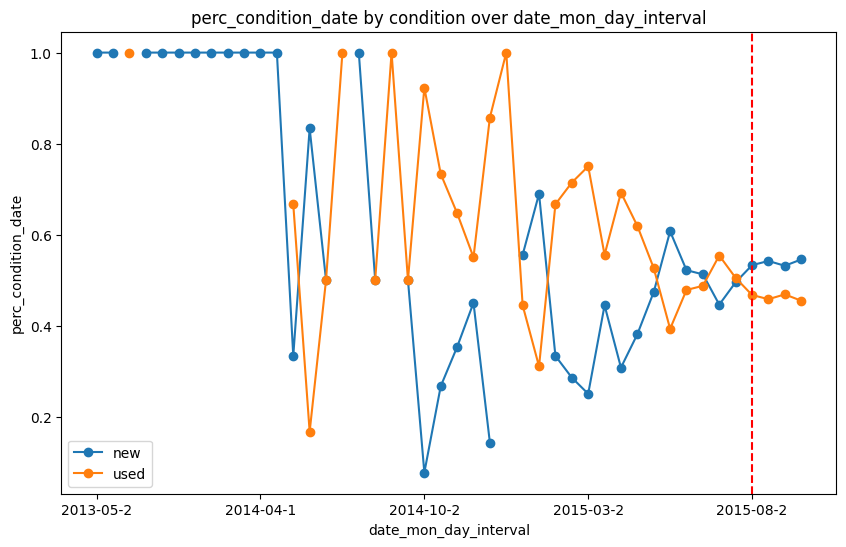

In [23]:
# Create lineplot for analysis
lineplot_target_date(
    data=df_condition_over_interval,
    date_column="date_mon_day_interval",
    target="condition",
    y_axis="perc_condition_date",
    threshold='2015-08-2'
)

**Comments**: The interval considered was to divide the month between **days 1-15 and 16-more** of each month. This approach was used to form at least **3 future folds** that respected the time in their splits. 

Looking at the last 20 records, we see how the volumetry only becomes significant when the variable *date_mon_day_interval* is greater than or equal to **2015-08-2**.

Therefore, all data prior to this value will be dropped from the dataset. It's not a big deal, considering we are removing **less than one thousand of records (< 1.00%)**.

In [24]:
# Filter dataframe
cleaned_new_or_used = cleaned_new_or_used.query("date_mon_day_interval >= '2015-08-2'")

# Sort values by new date column
cleaned_new_or_used = cleaned_new_or_used.sort_values(by=["date_mon_day_interval"])

# Drop temp vars
del df_condition_over_interval

# New dataframe dimensions
cleaned_new_or_used.shape

(99158, 49)

### **Filtering columns**

##### Unique Values

In [25]:
# Count unique values
unique_values(cleaned_new_or_used)

Column: 'seller_address' <> Unique values: 3981
Column: 'warranty' <> Unique values: 10214
Column: 'sub_status' <> Unique values: 4
Column: 'condition' <> Unique values: 2
Column: 'deal_ids' <> Unique values: 32
Column: 'base_price' <> Unique values: 10194
Column: 'shipping' <> Unique values: 40
Column: 'non_mercado_pago_payment_methods' <> Unique values: 188
Column: 'seller_id' <> Unique values: 35524
Column: 'variations' <> Unique values: 8153
Column: 'site_id' <> Unique values: 1
Column: 'listing_type_id' <> Unique values: 7
Column: 'price' <> Unique values: 10195
Column: 'attributes' <> Unique values: 2911
Column: 'buying_mode' <> Unique values: 3
Column: 'tags' <> Unique values: 8
Column: 'listing_source' <> Unique values: 1
Column: 'parent_item_id' <> Unique values: 76627
Column: 'coverage_areas' <> Unique values: 1
Column: 'category_id' <> Unique values: 10854
Column: 'descriptions' <> Unique values: 96488
Column: 'last_updated' <> Unique values: 94312
Column: 'international_del

2023-02-28 12:31:52,702 - Logger - INFO - Unique values succesfully counted for each column!


Column: 'date_created_mon' <> Unique values: 3
Column: 'day' <> Unique values: 31
Column: 'day_interval' <> Unique values: 2
Column: 'date_mon_day_interval' <> Unique values: 4


**Comments**: In this dataset, we have **5 columns** with only **1 unique values** (*site_id*, *listing_source*, *coverage_areas*, *differential_pricing*, *subtitle*). Constant values do not add info to our problem, so we will drop them.

##### Empty columns

Replace empty information to NaN

In [26]:
# Dealing with white spaces
cleaned_new_or_used = cleaned_new_or_used.replace(r'^\s*$', np.nan, regex=True)

# Fill NA with np.nan
cleaned_new_or_used = cleaned_new_or_used.fillna(value=np.nan)

# Replace 'none' with NaN
cleaned_new_or_used = cleaned_new_or_used.replace('none', np.nan)

Dataframe null values and dtypes

In [27]:
# Some basic informations about the dataframe
cleaned_new_or_used.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99158 entries, 66412 to 49977
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   seller_address                    99158 non-null  object             
 1   warranty                          38953 non-null  object             
 2   sub_status                        99158 non-null  object             
 3   condition                         99158 non-null  object             
 4   deal_ids                          99158 non-null  object             
 5   base_price                        99158 non-null  float64            
 6   shipping                          99158 non-null  object             
 7   non_mercado_pago_payment_methods  99158 non-null  object             
 8   seller_id                         99158 non-null  int64              
 9   variations                        99158 non-null  object 

**Comments**: Here, we have 4 completely **empty columns** (*differential_pricing*, *subtitle*, *listing_source* & *international_delivery_mode*) and another 2 columns whose non-null values **do not represent even 0.5%** of the dataset (*original_price*, *catalog_product_id*). This DOES NOT MEAN that they are not representative variables for the problem, but for THIS DATASET, the information is **volumetrically low** for the composition of a future model.

These features will also be delete.

In [28]:
# Drop unused raw features
cleaned_new_or_used = cleaned_new_or_used.drop(
    columns=[
        "date_created_mon", "day", "day_interval",  # Columns previously created
        "site_id",  # Constant columns
        "differential_pricing", "subtitle", 
        "listing_source", "international_delivery_mode",  # Empty columns
        "original_price", "catalog_product_id"  # Less than 0.5% not null
    ]
)

List/dict features

We saw that some columns are **dictionaries or lists** with nested information. We need to split this data to be able to get metrics about them.

First, we'll look at the number of **empty lists and dicts**.

In [29]:
# Call function built to count non-null values in this column type.
non_null_columns(
    data=cleaned_new_or_used,
    column_list=[
        "sub_status", "deal_ids", "non_mercado_pago_payment_methods",
        "variations", "attributes", "tags", "coverage_areas", "descriptions", "pictures"
    ]
)

'non_zero_list_columns' function results:

- Feature 'sub_status' <> Non Null Values = 978
- Feature 'deal_ids' <> Non Null Values = 233
- Feature 'non_mercado_pago_payment_methods' <> Non Null Values = 69221
- Feature 'variations' <> Non Null Values = 8152
- Feature 'attributes' <> Non Null Values = 11833
- Feature 'tags' <> Non Null Values = 74731
- Feature 'coverage_areas' <> Non Null Values = 0
- Feature 'descriptions' <> Non Null Values = 96487


2023-02-28 12:32:02,750 - Logger - INFO - Count not null values in a column succesfully done!


- Feature 'pictures' <> Non Null Values = 98370


**Comments**: In the same way, we're going to drop the features that the non-zero values do not correspond to at least 0.5% of the entire dataset (*deal_ids*, *coverage_areas*).

In [30]:
# Empty list for future store
dict_output_list = []

# Loop each value in the following list
for col in ["seller_address", "shipping"]:
    # Save dict column normalized as dataframe
    normalized_df = pd.json_normalize(cleaned_new_or_used[col])
    normalized_df = normalized_df.add_prefix(
        f'{col}_'
    )
    # Append values to the empty list
    dict_output_list.append(normalized_df)

# Delete itter variables
del col, normalized_df

In [31]:
# Inspect the dataframes stored as element in the list,
# printing some informations about them.
dict_columns_inspect(data_in_list=dict_output_list)

2023-02-28 12:32:05,632 - Logger - INFO - Checking nested informations succesfully done!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99158 entries, 0 to 99157
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   seller_address_country.name  99158 non-null  object
 1   seller_address_country.id    99158 non-null  object
 2   seller_address_state.name    99158 non-null  object
 3   seller_address_state.id      99158 non-null  object
 4   seller_address_city.name     99158 non-null  object
 5   seller_address_city.id       99158 non-null  object
dtypes: object(6)
memory usage: 4.5+ MB
None

------------------------------------------------------------------------------------------

      seller_address_country.name seller_address_country.id  \
0                       Argentina                        AR   
1                       Argentina                        AR   
2                       Argentina                        AR   
3                       Argentina             

In [32]:
# Again, count non-null values to each column
non_null_columns(
    data=dict_output_list[1],
    column_list=[
        "shipping_tags",
        "shipping_methods"
    ]
)

2023-02-28 12:32:05,785 - Logger - INFO - Count not null values in a column succesfully done!


'non_zero_list_columns' function results:

- Feature 'shipping_tags' <> Non Null Values = 68
- Feature 'shipping_methods' <> Non Null Values = 2971


**Comments**: For the *dictionaries*, there aren't **mostly empty dataframes** (just *dimensions*). For the lists INSIDE these dictionaries, the column *tags* has only **69 values not null** and *methods* just **3006**.

Dropping initial columns that will not be used

In [33]:
# Drop unused list features
cleaned_new_or_used = cleaned_new_or_used.drop(
    columns=[
        "sub_status", "deal_ids", "coverage_areas"  # List columns inspected
    ]
)

In [34]:
# Rows of the primary cleaned dataset
cleaned_new_or_used.head(5)

,seller_address,warranty,condition,base_price,shipping,non_mercado_pago_payment_methods,seller_id,variations,listing_type_id,price,attributes,buying_mode,tags,parent_item_id,category_id,descriptions,last_updated,pictures,id,official_store_id,accepts_mercadopago,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,video_id,initial_quantity,start_time,permalink,sold_quantity,available_quantity,date_mon_day_interval
66412,"{'country': {'name': 'Argentina', 'id': 'AR'},...",NaN,new,4500.000,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",6309630046,[],bronze,4500.000,[],buy_it_now,[dragged_bids_and_visits],MLA3553408060,MLA4761,[{'id': 'MLA5569012823-904670186'}],2015-08-26T19:56:18.000Z,"[{'size': '375x500', 'secure_url': 'https://a2...",MLA5569012823,NaN,True,ARS,http://mla-s1-p.mlstatic.com/594501-MLA5569012...,Mesa Artesanal - Diseño Exclusivo,False,2015-08-26 19:56:17+00:00,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-10-25 19:56:17,active,NaN,1,2015-08-26 19:56:17,http://articulo.mercadolibre.com.ar/MLA5569012...,0,1,2015-08-2
16397,"{'country': {'name': 'Argentina', 'id': 'AR'},...",Sí,used,40.000,"{'local_pick_up': False, 'methods': [], 'tags'...","[{'description': 'Transferencia bancaria', 'id...",2302325100,[],free,40.000,[],buy_it_now,[dragged_bids_and_visits],MLA2552875301,MLA41104,[{'id': 'MLA4321590423-898014895'}],2015-09-20T16:21:03.000Z,"[{'size': '375x500', 'secure_url': 'https://a2...",MLA4321590423,NaN,True,ARS,http://mla-s1-p.mlstatic.com/13520-MLA43215904...,Marlon Brando En Queimada / Revista La Nacion ...,False,2015-08-18 19:28:24+00:00,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-10-17 19:28:24,active,NaN,1,2015-08-18 19:28:24,http://articulo.mercadolibre.com.ar/MLA4321590...,0,1,2015-08-2
79284,"{'country': {'name': 'Argentina', 'id': 'AR'},...",Sin garantía,used,70.000,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8179118524,[],free,70.000,[],buy_it_now,[dragged_bids_and_visits],MLA1557421790,MLA1963,[{'id': 'MLA5627466779-898494760'}],2015-08-19T11:59:58.000Z,"[{'size': '500x334', 'secure_url': 'https://a2...",MLA5627466779,NaN,True,ARS,http://mla-s2-p.mlstatic.com/4073-MLA562746677...,Revista Monde Médical - Junio 1939 - Num 934,False,2015-08-19 11:58:51+00:00,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,2015-10-18 11:58:51,active,NaN,1,2015-08-19 11:58:51,http://articulo.mercadolibre.com.ar/MLA5627466...,0,1,2015-08-2
66365,"{'country': {'name': 'Argentina', 'id': 'AR'},...",Sí,used,20.000,"{'local_pick_up': False, 'methods': [], 'tags'...","[{'description': 'Efectivo', 'id': 'MLAMO', 't...",5597288044,[],bronze,20.000,[],buy_it_now,[dragged_bids_and_visits],MLA6681207150,MLA6009,[{'id': 'MLA8199445927-906980392'}],2015-08-29T22:48:40.000Z,"[{'size': '120x160', 'secure_url': 'https://a2...",MLA8199445927,NaN,True,ARS,http://mla-s2-p.mlstatic.com/6279-MLA819944592...,Sociedades Y Hombres Caryl P...,False,2015-08-29 22:48:38+00:00,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,2015-10-28 22:48:38,active,NaN,1,2015-08-29 22:48:38,http://articulo.mercadolibre.com.ar/MLA8199445...,0,1,2015-08-2
27852,"{'country': {'name': 'Argentina', 'id': 'AR'},...",NaN,used,240.000,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Efectivo', 'id': 'MLAMO', 't...",5976171738,[],free,240.000,[],buy_it_now,[dragged_bids_and_visits],MLA1065169171,MLA15171,[{'id': 'MLA4202324909-898180924'}],2015-08-18T22:34:23.000Z,"[{'size': '170x170', 'secure_url': 'https://a2...",MLA4202324909,NaN,True,ARS,http://mla-s1-p.mlstatic.com/10618-MLA42023249...,Ministry - Twitch Cd,False,2015-08-18 22:33:17+00:00,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-10-17 22:33:17,active,NaN,1,2015-08-18 22:33:17,http://articulo.mercadolibre.com.ar/MLA4202324...,0,1,2015-08-2


Handle list columns

Without jsons

In [35]:
# Keep columns list exploded as dataframe in a list
lists_exploded_no_json = explode_elements(
    data=cleaned_new_or_used,
    list_columns=["tags"]
)

2023-02-28 12:32:07,475 - Logger - INFO - Separate rows from column list succesfully done!


With jsons

In [36]:
""" Store separate rows and normalize jsons in a list
where each element is a pandas dataframe from the
column handled. """
explode_json_output = explode_normalize_lists(
    data=cleaned_new_or_used,
    list_columns=[
        "non_mercado_pago_payment_methods",
        "variations",
        "attributes",
        "descriptions",
        "pictures"
    ]
)

2023-02-28 12:32:24,797 - Logger - INFO - Explode lists and normalize dictionaries succesfully done!


Dataframe numerical variables

In [37]:
# Some descriptive statistics of the numerical features
cleaned_new_or_used.describe().applymap(lambda x: f"{x:0.1f}")

,base_price,seller_id,price,official_store_id,initial_quantity,sold_quantity,available_quantity
count,99158.0,99158.0,99158.0,815.0,99158.0,99158.0,99158.0
mean,51683.0,5490509532.9,51683.1,5778.4,35.1,2.3,34.9
std,8659542.1,2587233349.9,8659542.1,2658.9,421.5,42.6,421.3
min,0.8,1000078989.0,0.8,1024.0,1.0,0.0,1.0
25%,90.0,3191056127.8,90.0,3590.0,1.0,0.0,1.0
50%,250.0,5522609056.5,250.0,6043.0,1.0,0.0,1.0
75%,800.0,7704929703.0,800.0,8254.5,2.0,0.0,2.0
max,2222222222.0,9999852737.0,2222222222.0,9996.0,9999.0,8676.0,9999.0


**Comments**: It is very likely that a seller can sell a product almost **10,000 times**, but the *prices* appear to have outliers when their maximum value represents a number such as **2222222222.0**.

For the *quantity* variables, initially we will not do any treatment. As for the *price* features, we will analyze their **distribution** to check the best way to replace these values (or even drop them).

The *seller_id* and *official_store_id* columns are just an **identifiers**, meaning no numerical treatment.

2023-02-28 12:32:25,376 - Logger - INFO - Create process 'price_hist_plot' succesfully done!


array([<AxesSubplot: title={'center': 'new'}>,
       <AxesSubplot: title={'center': 'used'}>], dtype=object)

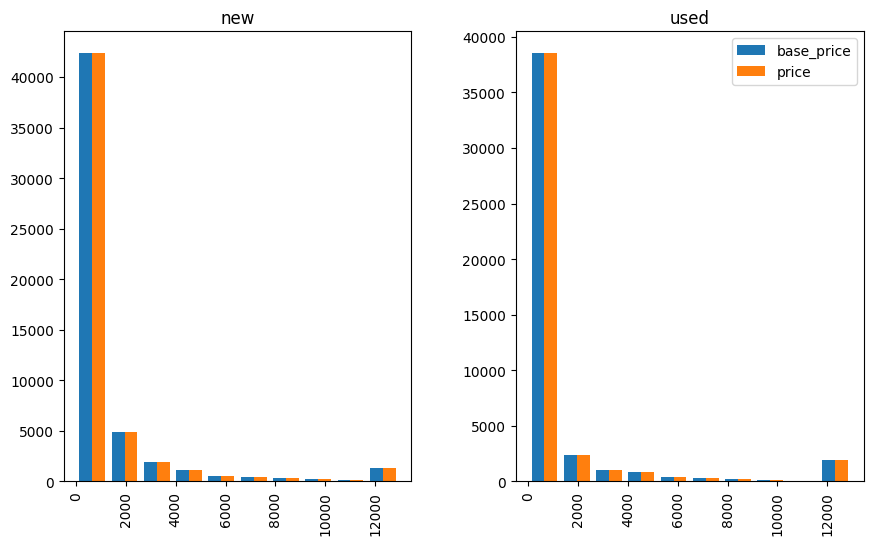

In [38]:
# Check histrogram of 'price' features
price_hist_plot(
    data=cleaned_new_or_used,
    quantile=0.97
)

**Comments**: The *price features* values has NO APPARENT DIFFERENTIATION in relation to the target *condition*.

Initially, **no data processing will be carried out**. Later on, if the exploratory analysis process indicates a discriminating force, we will see how to deal with these values (*if we have a hypothesis for these features over the product condition*).

At first glance, in order not to drop these discrepant values, we could **discretize** the features into **'n' categories** or replace these values by the **0.97 quantile**, for example.

However, considering that these features can be UPDATED after the ad initial publishing on marketplace, we will **not use them** for future analysis.

### **Dataframe for EDA**

To finalize this section, we create the dataframe to be used in the *EDA* phase and export it to facilitate our future job.

##### Selecting features from raw dataset

In [39]:
# Make a copy of the cleaned dataset
eda_new_or_used = cleaned_new_or_used.copy()

# Select features to be explored
eda_new_or_used = eda_new_or_used.loc[
    :, [
        "id", "seller_id", "parent_item_id",
        "category_id", "currency_id",
        "video_id", "official_store_id",  # identifiers
        "date_mon_day_interval", # datetimes
        "thumbnail", "secure_thumbnail",  # urls
        "accepts_mercadopago", "automatic_relist",  # booleans
        "warranty", "title",  # texts
        "buying_mode", "status", "listing_type_id",  # categoricals
        "initial_quantity",  # integers
        "condition"  # target column (Binary)
    ]
]

In [40]:
eda_new_or_used.head(5)

,id,seller_id,parent_item_id,category_id,currency_id,video_id,official_store_id,date_mon_day_interval,thumbnail,secure_thumbnail,accepts_mercadopago,automatic_relist,warranty,title,buying_mode,status,listing_type_id,initial_quantity,condition
66412,MLA5569012823,6309630046,MLA3553408060,MLA4761,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/594501-MLA5569012...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,NaN,Mesa Artesanal - Diseño Exclusivo,buy_it_now,active,bronze,1,new
16397,MLA4321590423,2302325100,MLA2552875301,MLA41104,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/13520-MLA43215904...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,Sí,Marlon Brando En Queimada / Revista La Nacion ...,buy_it_now,active,free,1,used
79284,MLA5627466779,8179118524,MLA1557421790,MLA1963,ARS,NaN,NaN,2015-08-2,http://mla-s2-p.mlstatic.com/4073-MLA562746677...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,True,False,Sin garantía,Revista Monde Médical - Junio 1939 - Num 934,buy_it_now,active,free,1,used
66365,MLA8199445927,5597288044,MLA6681207150,MLA6009,ARS,NaN,NaN,2015-08-2,http://mla-s2-p.mlstatic.com/6279-MLA819944592...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,True,False,Sí,Sociedades Y Hombres Caryl P...,buy_it_now,active,bronze,1,used
27852,MLA4202324909,5976171738,MLA1065169171,MLA15171,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/10618-MLA42023249...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,NaN,Ministry - Twitch Cd,buy_it_now,active,free,1,used


##### Adding dataframes from dict columns

In [41]:
# Using custom function to merge dfs stored
df_from_dicts = merge_dfs_list_index(output_list=dict_output_list)

# Selecting just a few columns (ignoring repeats and null ones)
df_from_dicts = df_from_dicts.loc[
    :, [
        "seller_address_country.id",
        "seller_address_state.id",
        "seller_address_city.id",
        "shipping_local_pick_up",
        "shipping_free_shipping",
        "shipping_mode"
    ]
]

2023-02-28 12:32:26,121 - Logger - INFO - Merging dataframes in a list by index succesfully done!


In [42]:
# Check how the structure will be merged to the eda dataframe
df_from_dicts.head(5)

,seller_address_country.id,seller_address_state.id,seller_address_city.id,shipping_local_pick_up,shipping_free_shipping,shipping_mode
0,AR,AR-C,TUxBQlZJTDc4MDda,True,False,not_specified
1,AR,AR-C,,False,False,me2
2,AR,AR-C,,True,False,me2
3,AR,AR-C,,False,False,me2
4,AR,AR-C,TUxBQlJFQzkyMTVa,True,False,not_specified


In [43]:
# Merge with eda dataset
eda_new_or_used = eda_new_or_used.merge(
    df_from_dicts,
    left_index=True,
    right_index=True
)

# Drop temp variables
del df_from_dicts

In [44]:
eda_new_or_used.head(5)

,id,seller_id,parent_item_id,category_id,currency_id,video_id,official_store_id,date_mon_day_interval,thumbnail,secure_thumbnail,accepts_mercadopago,automatic_relist,warranty,title,buying_mode,status,listing_type_id,initial_quantity,condition,seller_address_country.id,seller_address_state.id,seller_address_city.id,shipping_local_pick_up,shipping_free_shipping,shipping_mode
66412,MLA5569012823,6309630046,MLA3553408060,MLA4761,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/594501-MLA5569012...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,NaN,Mesa Artesanal - Diseño Exclusivo,buy_it_now,active,bronze,1,new,AR,AR-B,TUxBQ0xBUGxhdGE,True,False,me2
16397,MLA4321590423,2302325100,MLA2552875301,MLA41104,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/13520-MLA43215904...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,Sí,Marlon Brando En Queimada / Revista La Nacion ...,buy_it_now,active,free,1,used,AR,AR-C,,True,False,not_specified
79284,MLA5627466779,8179118524,MLA1557421790,MLA1963,ARS,NaN,NaN,2015-08-2,http://mla-s2-p.mlstatic.com/4073-MLA562746677...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,True,False,Sin garantía,Revista Monde Médical - Junio 1939 - Num 934,buy_it_now,active,free,1,used,AR,AR-B,,True,False,not_specified
66365,MLA8199445927,5597288044,MLA6681207150,MLA6009,ARS,NaN,NaN,2015-08-2,http://mla-s2-p.mlstatic.com/6279-MLA819944592...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,True,False,Sí,Sociedades Y Hombres Caryl P...,buy_it_now,active,bronze,1,used,AR,AR-C,TUxBQlJFVDgyMDVa,False,False,me2
27852,MLA4202324909,5976171738,MLA1065169171,MLA15171,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/10618-MLA42023249...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,NaN,Ministry - Twitch Cd,buy_it_now,active,free,1,used,AR,AR-B,,False,False,custom


##### Dataframes from exploded list columns

WITHOUT JSONS

In [45]:
# Dataframe with summarized data
explode_no_json_results = df_from_explode_no_json(target_list=lists_exploded_no_json)

2023-02-28 12:32:28,744 - Logger - INFO - Merging dataframes in a list by index succesfully done!
2023-02-28 12:32:28,745 - Logger - INFO - Summarizing nested informations succesfully done!


In [46]:
# See summary results for future merge
explode_no_json_results.head(5)

tags,id,tags_count_dragged_bids_and_visits,tags_count_dragged_visits,tags_count_free_relist,tags_count_good_quality_thumbnail,tags_count_poor_quality_thumbnail
0,MLA1000058677,1,0,0,0,0
1,MLA1000434568,1,0,0,0,0
2,MLA1000668594,1,0,0,0,0
3,MLA1000725925,1,0,0,0,0
4,MLA1000777227,1,0,0,0,0


In [47]:
# Merge with eda dataset in build process
eda_new_or_used = eda_new_or_used.merge(
    explode_no_json_results,
    on="id",
    how="left"
)

# Fill NA with 0 in '_count_'
agg_cols = [col for col in explode_no_json_results.columns if '_count_' in col]
eda_new_or_used[agg_cols] = eda_new_or_used[agg_cols].fillna(0).astype(int)

# Drop temp variables
del explode_no_json_results, agg_cols

In [48]:
eda_new_or_used.head(5)

,id,seller_id,parent_item_id,category_id,currency_id,video_id,official_store_id,date_mon_day_interval,thumbnail,secure_thumbnail,accepts_mercadopago,automatic_relist,warranty,title,buying_mode,status,listing_type_id,initial_quantity,condition,seller_address_country.id,seller_address_state.id,seller_address_city.id,shipping_local_pick_up,shipping_free_shipping,shipping_mode,tags_count_dragged_bids_and_visits,tags_count_dragged_visits,tags_count_free_relist,tags_count_good_quality_thumbnail,tags_count_poor_quality_thumbnail
0,MLA5569012823,6309630046,MLA3553408060,MLA4761,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/594501-MLA5569012...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,NaN,Mesa Artesanal - Diseño Exclusivo,buy_it_now,active,bronze,1,new,AR,AR-B,TUxBQ0xBUGxhdGE,True,False,me2,1,0,0,0,0
1,MLA4321590423,2302325100,MLA2552875301,MLA41104,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/13520-MLA43215904...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,Sí,Marlon Brando En Queimada / Revista La Nacion ...,buy_it_now,active,free,1,used,AR,AR-C,,True,False,not_specified,1,0,0,0,0
2,MLA5627466779,8179118524,MLA1557421790,MLA1963,ARS,NaN,NaN,2015-08-2,http://mla-s2-p.mlstatic.com/4073-MLA562746677...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,True,False,Sin garantía,Revista Monde Médical - Junio 1939 - Num 934,buy_it_now,active,free,1,used,AR,AR-B,,True,False,not_specified,1,0,0,0,0
3,MLA8199445927,5597288044,MLA6681207150,MLA6009,ARS,NaN,NaN,2015-08-2,http://mla-s2-p.mlstatic.com/6279-MLA819944592...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,True,False,Sí,Sociedades Y Hombres Caryl P...,buy_it_now,active,bronze,1,used,AR,AR-C,TUxBQlJFVDgyMDVa,False,False,me2,1,0,0,0,0
4,MLA4202324909,5976171738,MLA1065169171,MLA15171,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/10618-MLA42023249...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,NaN,Ministry - Twitch Cd,buy_it_now,active,free,1,used,AR,AR-B,,False,False,custom,1,0,0,0,0


WITH JSONS

In [49]:
# Json columns name in a list
normalized_col_names=[
    "non_mercado_pago_payment_methods",
    "variations",
    "attributes",
    "descriptions",
    "pictures"
]

# Zip their names with the dataframes in a list
data_name_list = list(zip(explode_json_output, normalized_col_names))

# Call function to count occurances of each json
df_from_jsons_count = count_from_jsons(data_name_list)

2023-02-28 12:32:30,818 - Logger - INFO - Count rows after normalize jsons in each one succesfully done!


In [50]:
# View counter for jsons columns structure
df_from_jsons_count.head(5)

,id,non_mercado_pago_payment_methods_id_count,variations_id_count,attributes_id_count,pictures_id_count
0,MLA1000058677,2,0,0,1
1,MLA1000182804,1,0,0,2
2,MLA1000356806,1,0,0,1
3,MLA1000434568,4,0,0,3
4,MLA1000488061,2,0,0,1


In [51]:
# Final merge to eda dataset
eda_new_or_used = eda_new_or_used.merge(
    df_from_jsons_count,
    on="id",
    how="left"
)

# Drop temp df
del df_from_jsons_count

In [52]:
eda_new_or_used.head(5)

,id,seller_id,parent_item_id,category_id,currency_id,video_id,official_store_id,date_mon_day_interval,thumbnail,secure_thumbnail,accepts_mercadopago,automatic_relist,warranty,title,buying_mode,status,listing_type_id,initial_quantity,condition,seller_address_country.id,seller_address_state.id,seller_address_city.id,shipping_local_pick_up,shipping_free_shipping,shipping_mode,tags_count_dragged_bids_and_visits,tags_count_dragged_visits,tags_count_free_relist,tags_count_good_quality_thumbnail,tags_count_poor_quality_thumbnail,non_mercado_pago_payment_methods_id_count,variations_id_count,attributes_id_count,pictures_id_count
0,MLA5569012823,6309630046,MLA3553408060,MLA4761,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/594501-MLA5569012...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,NaN,Mesa Artesanal - Diseño Exclusivo,buy_it_now,active,bronze,1,new,AR,AR-B,TUxBQ0xBUGxhdGE,True,False,me2,1,0,0,0,0,2,0,0,3
1,MLA4321590423,2302325100,MLA2552875301,MLA41104,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/13520-MLA43215904...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,Sí,Marlon Brando En Queimada / Revista La Nacion ...,buy_it_now,active,free,1,used,AR,AR-C,,True,False,not_specified,1,0,0,0,0,3,0,0,1
2,MLA5627466779,8179118524,MLA1557421790,MLA1963,ARS,NaN,NaN,2015-08-2,http://mla-s2-p.mlstatic.com/4073-MLA562746677...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,True,False,Sin garantía,Revista Monde Médical - Junio 1939 - Num 934,buy_it_now,active,free,1,used,AR,AR-B,,True,False,not_specified,1,0,0,0,0,2,0,0,4
3,MLA8199445927,5597288044,MLA6681207150,MLA6009,ARS,NaN,NaN,2015-08-2,http://mla-s2-p.mlstatic.com/6279-MLA819944592...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,True,False,Sí,Sociedades Y Hombres Caryl P...,buy_it_now,active,bronze,1,used,AR,AR-C,TUxBQlJFVDgyMDVa,False,False,me2,1,0,0,0,0,1,0,0,1
4,MLA4202324909,5976171738,MLA1065169171,MLA15171,ARS,NaN,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/10618-MLA42023249...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,NaN,Ministry - Twitch Cd,buy_it_now,active,free,1,used,AR,AR-B,,False,False,custom,1,0,0,0,0,1,0,0,1


**Comments**: We're NOT GOING to analyze the data **all the columns** in this way on the *Exploratory Data Analysis* second stage. Some of them will be converted as *boolean*, others will be *categorized* or even not be used.

We're writing the dataframe just to make our future job much **easier** when we want to transform any of these features.

##### Exporting new dataset

In [53]:
try:
    # Declaring output file name
    OUTPUT_FILE = "eda_new_or_used.parquet"
    # Convert the DataFrame to a PyArrow table
    table = pa.Table.from_pandas(eda_new_or_used)
    # Write the PyArrow table to a Parquet file
    pq.write_table(
        table,
        os.path.join(os.getcwd(), 'outputs', OUTPUT_FILE)
    )
    # Execution success log
    log.info("Dataframe succesfully exported as a parquet file!")
    # Delete temp variables
    del OUTPUT_FILE, table
except ImportError:
    # Execution error log
    log.error("Something went wrong... Could not export pandas dataframe as a parquet file!")

2023-02-28 12:32:31,998 - Logger - INFO - Dataframe succesfully exported as a parquet file!


### **Requirements**

In addition, if you want to run this code locally, a *requirements file* will be created with the **name of the packages and their versions** used in this jupyter notebook.

In [54]:
try:
    # Declaring path to file
    TEXT_FILE_NAME = 'requirements_dwr.txt'
    text_path = os.path.join(os.path.dirname(os.getcwd()), TEXT_FILE_NAME)
    # Checking: If file exists, then drop it.
    if os.path.exists(text_path) == True:
        os.remove(text_path)
    # Creating txt file
    with open(file=text_path, mode="w", encoding="utf-8") as f:
        # Listing libraries and their version
        PACKAGES = '\n'.join(
            f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)
        )
        # Writing information
        f.write(PACKAGES)
        # Closing final file
        f.close()
    # # Execution success log
    log.info(
        "File '%s' containing the list of packages to be installed succesfully built!",
        TEXT_FILE_NAME
    )
except ImportError:
    # Execution error log
    log.error(
        "Something went wrong... Could not build the list of packages to be installed in '%s' file.",
        TEXT_FILE_NAME
    )

2023-02-28 12:32:32,085 - Logger - INFO - File 'requirements_dwr.txt' containing the list of packages to be installed succesfully built!
